# Explore Decoupled Intelligence

The proposal/hypothesis is here https://docs.google.com/document/d/1x7n2iy1_LZXZNLQpxCzF84lZ8BEG6ZT3KWXC59erhJA

This notebook investigates the **Structural Separation** hypothesis:
- Models contain distinct circuits for prompt categorization and response generation
- Categorization circuits are invariant to specific numeric inputs


In [36]:
# CatGen (singleton) config class
class CG:
    # Model we are testing
    MODEL_NAME = "gpt2-small"

    # We assume model uses Layer 8 as the likely 'Categorization Layer'
    MODEL_LAYER = 8

    # Number of mathematical tasks we test
    NUM_TEST_TASKS = 6

    # We test each task using 5 pairs of numbers
    NUMBER_PAIRS = [(25, 9), (42, 11), (7, 3), (99, 1), (15, 15)]
    NUM_NUM_PAIRS = len(NUMBER_PAIRS)

    IN_COLAB = False

## Step 1: Import Libraries

In [37]:
import sys
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from transformer_lens import HookedTransformer
from sklearn.decomposition import PCA

In [38]:
!pip install transformer-lens

In [39]:
try:
    import google.colab
    CG.IN_COLAB = True
except:
    CG.IN_COLAB = False

In [40]:
if CG.IN_COLAB:
    !pip install --upgrade git+https://github.com/PhilipQuirke/LlmPromptCategorization.git -q
else:
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import MathsCatGen as mcg

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Step 2: Load open-source model

In [41]:
model = HookedTransformer.from_pretrained(CG.MODEL_NAME, device="cuda" if torch.cuda.is_available() else "cpu")


Loaded pretrained model gpt2-small into HookedTransformer


## Step 3: Define Tasks
We use the core math tasks that share identical phrasing up until the final task-identifying word .

In [42]:
tasks = mcg.get_maths_tasks()[0:CG.NUM_TEST_TASKS]
print(tasks)

['minimum', 'maximum', 'sum', 'difference', 'product', 'average']


In [43]:
# Generate the prompt list
all_prompts = []
metadata = [] # To track task and pair for each prompt
for task in tasks:
    for n1, n2 in CG.NUMBER_PAIRS:
        all_prompts.append(f"Answer minimally: Given the numbers {n1} and {n2} calculate the {task}")
        metadata.append({"task": task, "pair": f"({n1},{n2})"})

## Step 4: Extract Residual Stream Activations
To isolate the "Categorization Layer", you should extract the activations from the residual stream at the final token position across all layers. The final token (the task word) is where the categorization is finalized.

In [44]:
activations = []

for prompt in all_prompts:
    with torch.no_grad():
        logits, cache = model.run_with_cache(prompt)
        # resid_post at the final token position
        vec = cache["resid_post", CG.MODEL_LAYER][0, -1, :].detach().cpu()
        activations.append(vec)

activations_tensor = torch.stack(activations)

## Step 5: Disentangling Categorization from Data

We subtract the average prompt "template" to find the task-specific vectors

In [45]:
# Calculate global mean (centroid) to remove template bias
global_centroid = activations_tensor.mean(dim=0)
task_specific_vectors = activations_tensor - global_centroid

## Step 6: Visualization: Similarity Heatmap

A powerful way to visualize this disentanglement is to create a similarity heatmap of all prompts (NUM_TEST_TASKS × NUM_NUM_PAIRS):
- You should see NUM_TEST_TASKS distinct "blocks" along the diagonal.
- Each block represents a task (e.g., all "sum" prompts).
- High similarity in a block = Stability across the pairs of numbers
- Low similarity between blocks = Different activations for different tasks => clear categorization between tasks.

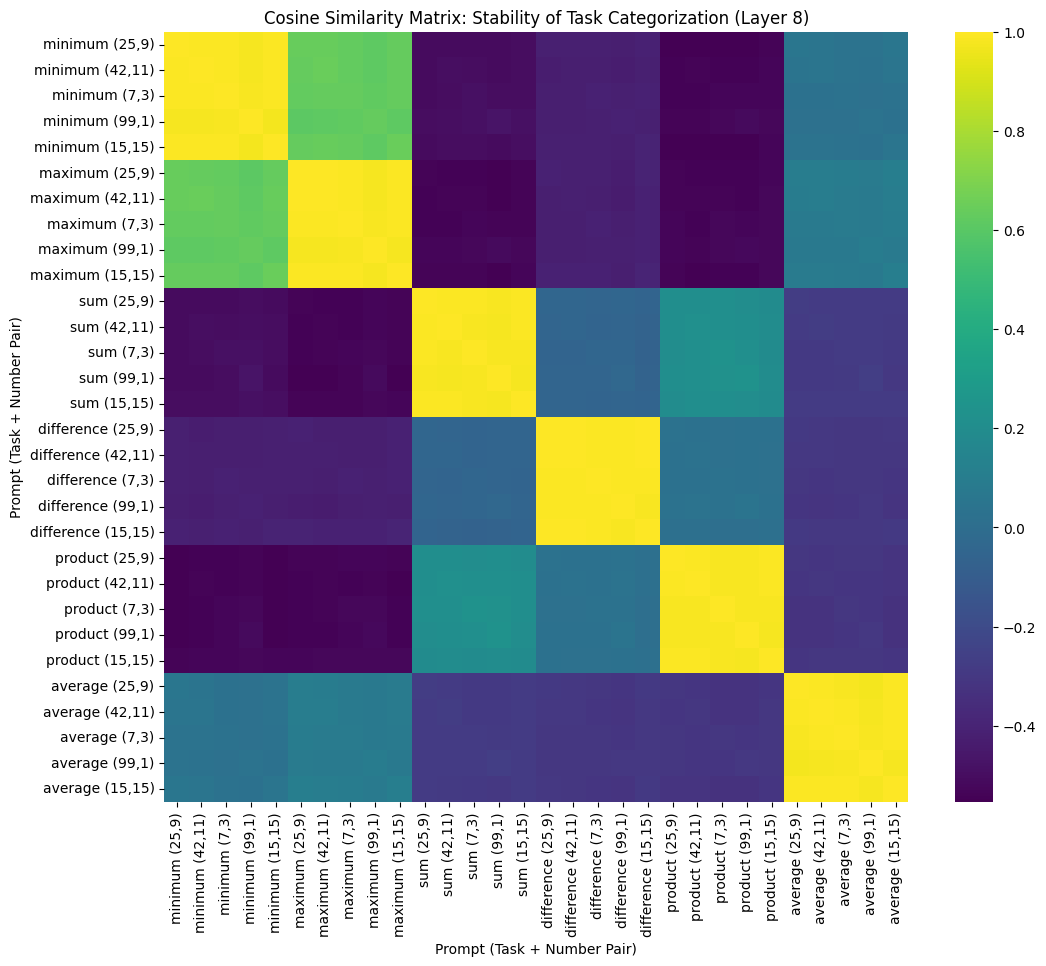

In [46]:
# Normalize for cosine similarity
norm_vecs = F.normalize(task_specific_vectors, p=2, dim=1)
sim_matrix = torch.mm(norm_vecs, norm_vecs.t()).numpy()

plt.figure(figsize=(12, 10))
labels = [f"{m['task']} {m['pair']}" for m in metadata]
sns.heatmap(sim_matrix, xticklabels=labels, yticklabels=labels, cmap="viridis", annot=False)
plt.title(f"Cosine Similarity Matrix: Stability of Task Categorization (Layer {CG.MODEL_LAYER})")
plt.xlabel("Prompt (Task + Number Pair)")
plt.ylabel("Prompt (Task + Number Pair)")
plt.show()

## Step 7. Visualization: PCA Projection

We project the NUM_TEST_TASKS × NUM_NUM_PAIRS vectors into 2D space to see the "Task Clusters"

If the "Structural Separation" hypothesis is true, these task clusters should be geometrically distant in the PCA plot. This is useful but weak evidence.

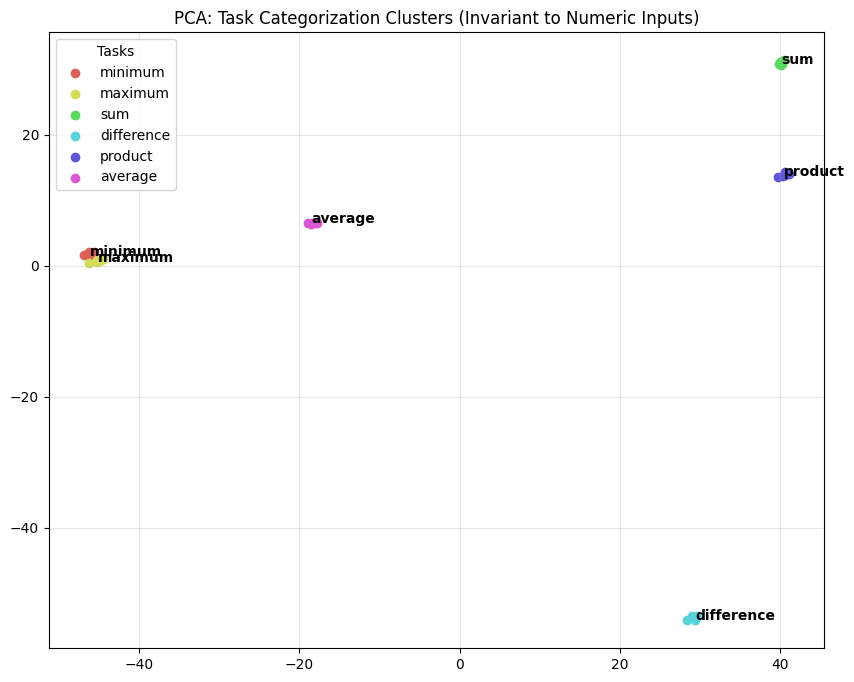

In [47]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(task_specific_vectors.numpy())

plt.figure(figsize=(10, 8))
colors = sns.color_palette("hls", len(tasks))
task_colors = {task: colors[i] for i, task in enumerate(tasks)}

for i, meta in enumerate(metadata):
    plt.scatter(
        pca_results[i, 0],
        pca_results[i, 1],
        color=task_colors[meta['task']],
        label=meta['task'] if i % 5 == 0 else ""
    )
    # Label a few points
    if i % 5 == 0:
        plt.text(pca_results[i, 0] + 0.05, pca_results[i, 1] + 0.05, meta['task'], weight='bold')

plt.legend(title="Tasks")
plt.title("PCA: Task Categorization Clusters (Invariant to Numeric Inputs)")
plt.grid(True, alpha=0.3)
plt.show()

## What these results show

- Intra-Task Consistency: The 5x5 blocks on the heatmap diagonal show how similar "sum (25,9)" is to "sum (99,1)". High similarity here confirms the categorization circuit is ignoring numeric noise.

- Inter-Task Orthogonality: The dark regions between blocks represent the separation between tasks. If the "Structural Separation" hypothesis is true, these task clusters should be geometrically distant in the PCA plot.

- Scale Coordination: You can observe if the clusters are roughly the same distance from the center, which would support the idea that the model uses a unified activation scale for all 100 tasks